In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import unittest
from numba import njit

%matplotlib notebook

G = 6.67430e-11 # м^3 кг^-1 с^-2

In [2]:
@njit("Tuple((float64[:], boolean))(float64[:, :], float64[:], float64[:], float64[:], float64)", 
      nogil=True, fastmath=True)
def calc_acceleration(bodies_X, bodies_M, bodies_R, X, R):
    """
    Расчет ускорения тела по данным о других телах.

    Parameters
    ----------
    bodies_X : np.ndarray
        Координаты тел в виде матрицы.
    bodies_M : np.ndarray
        Массы тел в виде вектора.
    bodies_R : np.ndarray
        Радиусы тел в виде вектора.
    X : np.ndarray
        Вектор координат тела.
    R : float
        Радиус тела.
        
    Returns
    ----------
    A : np.ndarray
        Вектор ускорения тела.
    is_destroyed : bool
        Разрушено ли тело в данный момент времени.
    """
    bodies_X -= X
    distance = np.sqrt(
        np.sum(bodies_X ** 2, axis=1)
    ) # np.linalg.norm(axis=1) не поддерживается numba.
    return np.sum(bodies_X.T * (G * bodies_M / distance ** 3), axis=1), np.any(distance < R + bodies_R)

In [3]:
class Star:
    def __init__(self, mass: float, R: float = 0.):
        """
        Создание объекта звезды.
        
        Parameters
        ----------
        mass : float
            Масса звезды.
        R : float
            Радиус звезды.
        """
        self.M = mass
        self.X = 0.
        self.R = R

In [4]:
class CosmicBody:
    def __init__(self, mass: float, pos: list, vel: list, R: float = 0., appearance_time: float = 0.):
        """
        Создание объекта космического тела.
        
        Parameters
        ----------
        mass : float
            Масса тела.
        pos : list
            Вектор положения тела.
        vel : list
            Вектор скорости тела.
        R : float
            Радиус тела.
        appearance_time : float
            Время появления тела.
        """
        self.M = mass
        self.X = np.array(pos, dtype=np.float64)
        self.V = np.array(vel, dtype=np.float64)
        self.A = np.zeros_like(self.V, dtype=np.float64)
        self.R = R
        self.appearance_time = appearance_time
        self.destroyed = False
    
    def gravitate(self, bodies: list):
        """
        Расчет ускорения тела.
        
        Parameters
        ----------
        bodies : list[CosmicBody]
            Список тел, с которыми нужно расчитать взаимодействие.
        """
        bodies_X = np.zeros((len(bodies), self.X.shape[0]))
        bodies_M = np.zeros(len(bodies))
        bodies_R = np.zeros(len(bodies))
        for i, body in enumerate(bodies):
            bodies_X[i] = body.X
            bodies_M[i] = body.M
            bodies_R[i] = body.R
            
        self.A, destroyed = calc_acceleration(bodies_X, bodies_M, bodies_R, self.X, self.R)
        if destroyed:
            self.destroy()
            
    def step(self, dt: float):
        """
        Обновление координат и скоростей по расчитанным ускорениям.
        
        Parameters
        ----------
        dt : float
            Шаг по времени.
        """
        self.X += self.V * dt + self.A * dt ** 2 / 2
        self.V += self.A * dt
        
    def is_alive(self, T : float) -> bool:
        """
        Создание объекта космического тела.
        
        Parameters
        ----------
        T : float
            Время в системе тел.
        
        Returns
        ----------
        is_alive : bool
            Состояние тела на данный момент.
        """
        return not self.destroyed and T > self.appearance_time
        
    def destroy(self):
        """
        Уничтожение тела в результате столкновения.
        """
        self.destroyed = True

In [5]:
class System:
    def __init__(self, star: Star, bodies: list[CosmicBody], dt: float = 1e-3):
        """
        Создание объекта системы космических тел.
        
        Parameters
        ----------
        star : Star
            Звезда в системе.
        bodies : list[CosmicBody]
            Космические тела в системе.
        dt : float
            Шаг расчета ускорений.
        """
        self.star = star
        self.bodies = bodies
        self.t = [0.]
        self.dt = dt
        self.trajectories = [[body.X.copy()] for body in self.bodies]
        
    def save_state(self):
        """
        Сохранение положений тел.
        """
        for i, body in enumerate(self.bodies):
            self.trajectories[i].append(body.X.copy())
    
    def calc_trajectories(self, T: float):
        """
        Расчет траекторий движения тел.
        
        Parameters
        ----------
        T : float
            Конечное время, до которого расчитываются траектории в системе.
        """
        while self.t[-1] < T:
            self.t.append(self.t[-1] + self.dt)
            bodies = [body for body in self.bodies if body.is_alive(self.t[-1])]
            for i, body in enumerate(bodies):
                body.gravitate([self.star, *bodies[:i], *bodies[i+1:]])
            for body in bodies:
                body.step(self.dt)
            self.save_state()
        else:
            print("All trajectories were calculated")   
            
    def orbit_types(self) -> list[str]:
        """
        Вычисление типа орбиты.
        
        Returns
        ----------
        orb_types : list[str]
            Тип орбиты ([гипербола, парабола, эллипс]).
        """
        orb_types = []
        for body in self.bodies:
            E = np.linalg.norm(body.V) ** 2 / 2 - G * self.star.M / np.linalg.norm(body.X)
            if E > 0:
                orb_types.append("гипербола")
            elif E < 0:
                orb_types.append("эллипс")
            else:
                orb_types.append("парабола")
        return orb_types
            
    def draw2D(self, speed: float = 1):
        """
        Визуализация траекторий объектов для двумерного случая.
        """
        fig, ax = plt.subplots()
        ax.set_aspect("equal")
        
        lines = []
        bodies = []
        for _ in self.trajectories:
            lines.append(ax.plot([], [], 'b')[0])
            bodies.append(ax.plot([], [], 'bo')[0])
            
        trajectories = np.array(self.trajectories)
        max_ = np.abs(trajectories).max() * 1.1
        ax.axis([-max_, max_, -max_, max_])
        ax.plot(0, 0, 'ro')
        
        def animate(step):
            i = int(speed * step)
            for line, body, trajectory in zip(lines, bodies, trajectories):
                line.set_data(trajectory[:i, 0], trajectory[:i, 1])
                body.set_data(trajectory[i, 0], trajectory[i, 1])

        return FuncAnimation(fig, animate, frames=len(self.t) // speed, interval=40)
    
    def draw3D(self, speed: float = 1):
        """
        Визуализация траекторий объектов для трехмерного случая.
        """
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        lines = []
        bodies = []
        for _ in self.trajectories:
            lines.append(ax.plot([], [], [], 'b')[0])
            bodies.append(ax.plot([], [], [], 'bo')[0])

        trajectories = np.array(self.trajectories)
        if trajectories.shape[-1] < 3:
            tmp = np.zeros((*trajectories.shape[:-1], 3))
            tmp[:, :, :trajectories.shape[-1]] = trajectories
            trajectories = tmp
        
        max_ = np.abs(trajectories).max() * 1.1
        ax.axes.set_xlim3d(-max_, max_)
        ax.axes.set_ylim3d(-max_, max_)
        ax.axes.set_zlim3d(-max_, max_)
        ax.plot(0, 0, 0, 'ro')
        
        def animate(step):
            i = int(speed * step)
            for line, body, trajectory in zip(lines, bodies, trajectories):
                line.set_data(trajectory[:i, 0], trajectory[:i, 1])
                line.set_3d_properties(trajectory[:i, 2])
                body.set_data(trajectory[i, 0], trajectory[i, 1])
                body.set_3d_properties(trajectory[i, 2])

        return FuncAnimation(fig, animate, frames=len(self.t) // speed, interval=40)

In [6]:
class StarTest(unittest.TestCase):
    def test_init(self):
        star = Star(mass=1, R=2)
        self.assertEqual(star.X, 0)
        self.assertEqual(star.M, 1)
        self.assertEqual(star.R, 2)
        
        
class CosmicBodyTest(unittest.TestCase):
    def test_init(self):
        body = CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)
        self.assertEqual(body.M, 0)
        self.assertEqual(body.X.tolist(), [1, 2, 3])
        self.assertEqual(body.V.tolist(), [4, 5, 6])
        self.assertEqual(body.A.tolist(), [0, 0, 0])
        self.assertEqual(body.R, 7)
        self.assertEqual(body.appearance_time, 8)
        self.assertFalse(body.destroyed)
        
    def test_gravitate(self):
        body = CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)
        body.gravitate([CosmicBody(mass=1 / G, pos=[11, 12, 13], vel=[14, 15, 16], R=7, appearance_time=8)])
        a = 10 / (10 ** 2 + 10 ** 2 + 10 ** 2) ** (3/2)
        np.testing.assert_almost_equal(body.A, [a, a, a])
        
    def test_step(self):
        body = CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)
        body.A = np.array([10, 20, 30])
        body.step(1)
        self.assertEqual(body.X.tolist(), [10, 17, 24])
        self.assertEqual(body.V.tolist(), [14, 25, 36])
        
    def test_is_alive(self):
        body = CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)
        self.assertFalse(body.is_alive(7.9))
        self.assertTrue(body.is_alive(8.1))
        
    def test_destroy(self):
        body = CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=0)
        self.assertTrue(body.is_alive(1))
        body.destroy()
        self.assertFalse(body.is_alive(1))
        
    
class SystemTest(unittest.TestCase):
    def test_init(self):
        system = System(
            Star(mass=1 / G, R=1), 
            [CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)], 
            dt=9
        )
        self.assertEqual(system.star.M, 1 / G)
        self.assertEqual(system.star.R, 1)
        self.assertEqual(len(system.bodies), 1)
        self.assertEqual(system.t, [0])
        self.assertEqual(system.dt, 9)
        self.assertEqual(len(system.trajectories), 1)
        self.assertEqual(len(system.trajectories[0]), 1)
        self.assertEqual(system.trajectories[0][0].tolist(), [1, 2, 3])
        
    def test_save_state(self):
        system = System(
            Star(mass=1 / G, R=1), 
            [CosmicBody(mass=0, pos=[1, 2, 3], vel=[4, 5, 6], R=7, appearance_time=8)],
            dt=9
        )
        system.save_state()
        self.assertEqual(len(system.trajectories), 1)
        self.assertEqual(len(system.trajectories[0]), 2)
        self.assertEqual(system.trajectories[0][0].tolist(), [1, 2, 3])
        self.assertEqual(system.trajectories[0][1].tolist(), [1, 2, 3])
        
    def test_calc_trajectories(self):
        system = System(
            Star(mass=1 / G, R=0), 
            [CosmicBody(mass=0, pos=[1, 2, 2], vel=[4, 5, 6], R=0, appearance_time=8)],
            dt=9
        )
        system.calc_trajectories(90)
        self.assertEqual(len(system.trajectories), 1)
        self.assertEqual(len(system.trajectories[0]), 11)
        self.assertEqual(system.trajectories[0][0].tolist(), [1, 2, 2])
        self.assertEqual(system.trajectories[0][1].tolist(), [35.5, 44, 53])
        
    def test_orbit_types(self):
        system = System(Star(mass=1 / G, R=0), [
            CosmicBody(mass=0, pos=[0.25, 0, 0], vel=[2, 0, 0]),
            CosmicBody(mass=0, pos=[ 0.5, 0, 0], vel=[2, 0, 0]),
            CosmicBody(mass=0, pos=[   1, 0, 0], vel=[2, 0, 0]),
        ], dt=9)
        self.assertEqual(system.orbit_types(), ['эллипс', 'парабола', 'гипербола'])

In [7]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_destroy (__main__.CosmicBodyTest) ... ok
test_gravitate (__main__.CosmicBodyTest) ... ok
test_init (__main__.CosmicBodyTest) ... ok
test_is_alive (__main__.CosmicBodyTest) ... ok
test_step (__main__.CosmicBodyTest) ... ok
test_init (__main__.StarTest) ... ok
test_calc_trajectories (__main__.SystemTest) ... ok
test_init (__main__.SystemTest) ... ok
test_orbit_types (__main__.SystemTest) ... ok
test_save_state (__main__.SystemTest) ... 

All trajectories were calculated


ok

----------------------------------------------------------------------
Ran 10 tests in 2.280s

OK


In [8]:
day = 24 * 60 * 60

system = System(
    Star(mass=1.99e30, R=6.95e8), # Солнце
    [
        CosmicBody(mass=3.33e23, pos=[0, 4.6e10,  0], vel=[0, 0, 49.4e3], R=2.44e6), # Меркурий
        CosmicBody(mass=4.87e24, pos=[1.07e11, 0, 0], vel=[0, 35.0e3, 0], R=6.05e6), # Венера
        CosmicBody(mass=5.97e24, pos=[1.47e11, 0, 0], vel=[0, 0, 29.8e3], R=6.4e6),  # Земля
        CosmicBody(mass=6.42e23, pos=[0, 2.07e11, 0], vel=[24.1e3, 0, 0], R=3.4e6, appearance_time=30 * day), # Марс
    ],
    dt=10 * 60 # 10 min
)

In [9]:
system.calc_trajectories(365 * day) # one year

All trajectories were calculated


Типы орбит: эллипс, эллипс, эллипс, эллипс


<IPython.core.display.Javascript object>


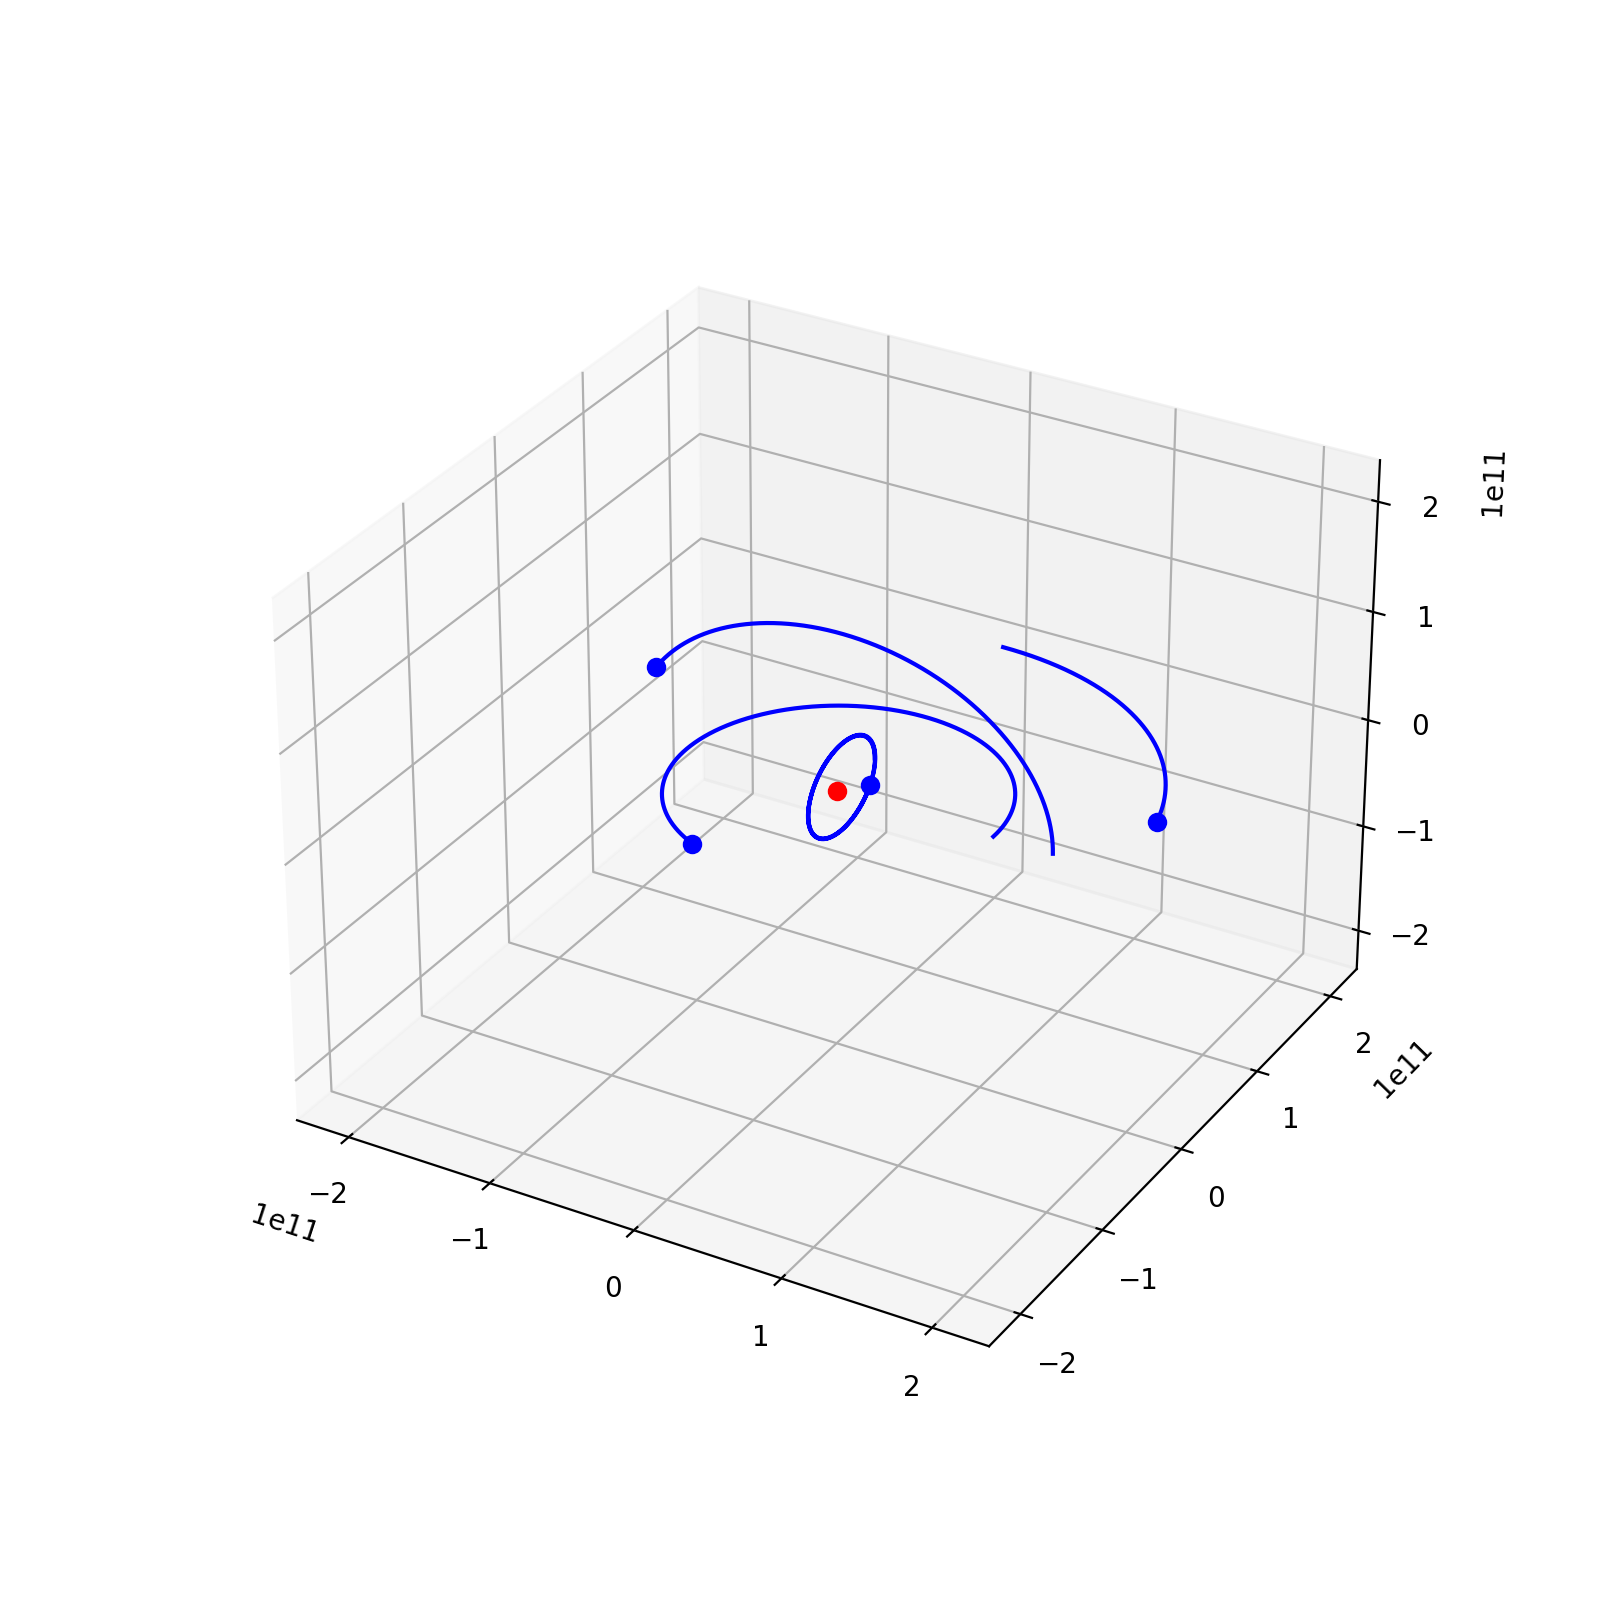

In [10]:
print("Типы орбит:", ", ".join(system.orbit_types()))
system.draw3D(speed=100)

<IPython.core.display.Javascript object>


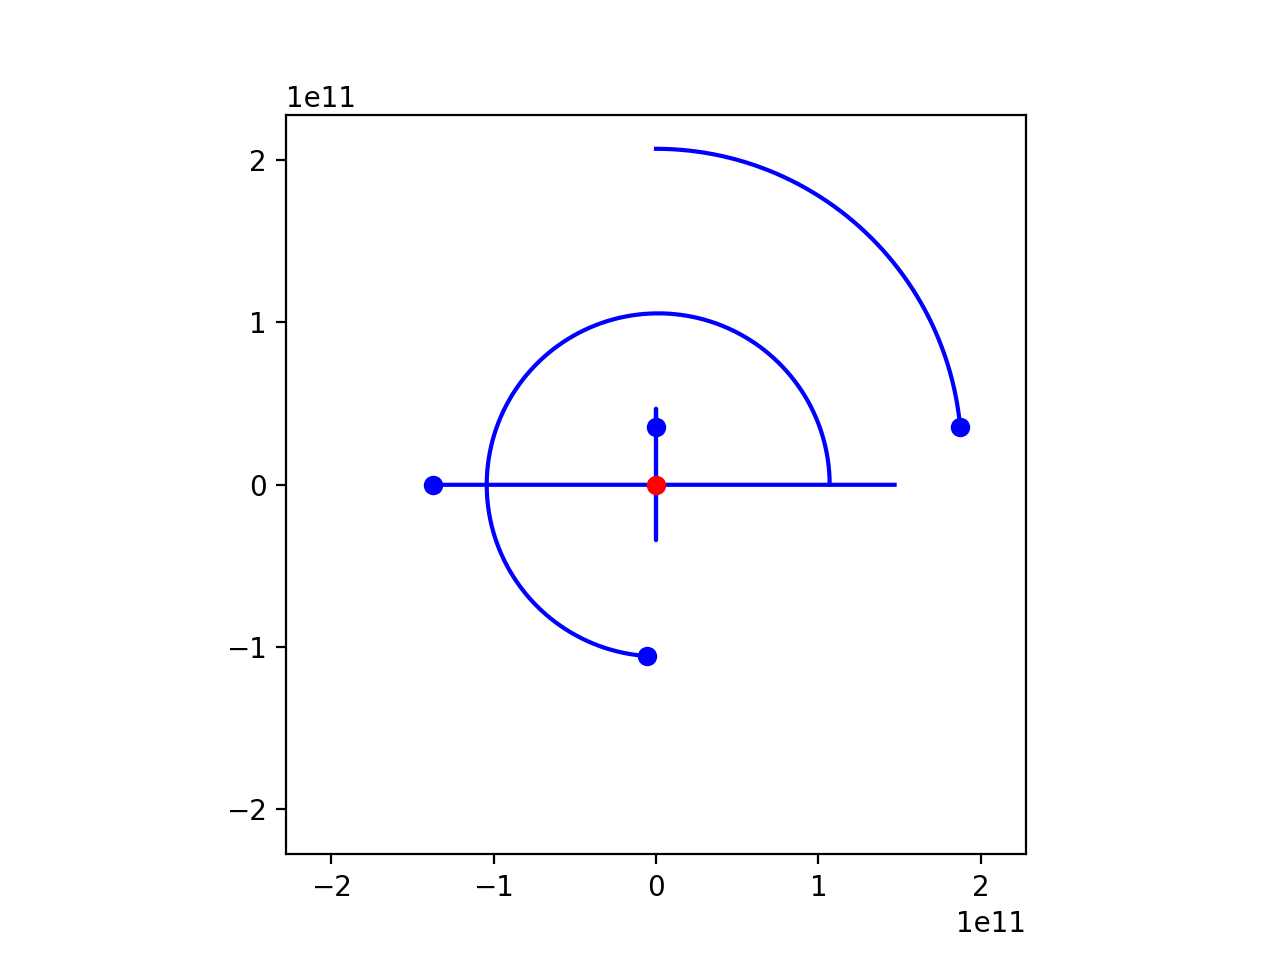

In [11]:
system.draw2D(speed=100)